Output()

train_loss    0.285384
valid_loss    0.394961
grad_norm     0.156520
train_acc     0.920685
valid_acc     0.918750
dtype: float64

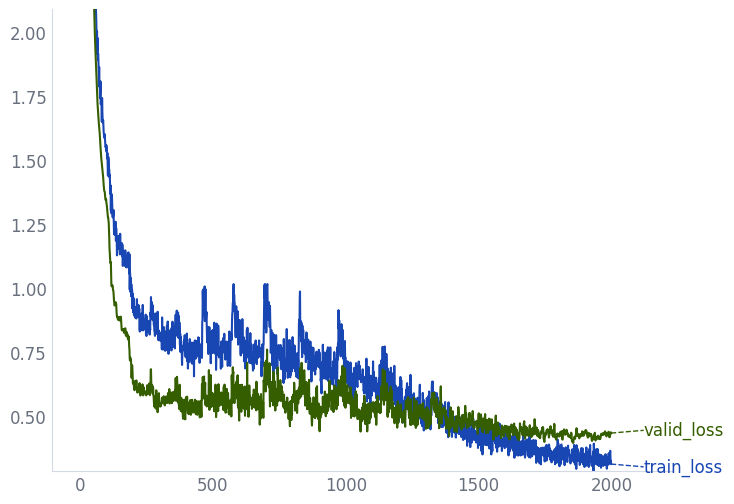

In [75]:
# jax.config.update('jax_debug_nans', True)
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rho_plus as rp
import seaborn as sns
from eins import ElementwiseOps as E
from flax import linen as nn
from penzai import pz

from jax_kan.trainer import Trainer

theme, cs = rp.mpl_setup(False)

import optax
import rich

from jax_kan.data import DataFrameDataLoader
from jax_kan.function_basis import Chebyshev, FixedInputMap, Fourier, Gegenbauer, Hermite, InputMap, Jacobi, Legendre, PolyInputMap
from jax_kan.kan import KAN, KANLayer
from jax_kan.utils import Identity
from jax_kan.function_basis import FunctionBasis
from jaxtyping import Float, Array


rich.console.Console()
rich.reconfigure(force_jupyter=True, width=250)

class HermiteScaled(FunctionBasis):
    """Hermite polynomials (physicist's version.)"""

    def __init__(self, n_coefs: int):
        super().__init__(n_coefs)

    @property
    def n_coefs(self) -> int:
        return self._n_coefs

    def design_matrix(self, x: Float[Array, '']) -> Float[Array, 'coefs={self.n_coefs}']:
        polys = [1, 2 * x]

        for n in range(2, self.n_coefs + 1):
            polys.append(2 * x * polys[-1] - 2 * (n - 1) * polys[-2])

        nn = jnp.arange(self.n_coefs + 1)
        # scale = jnp.sqrt(jnp.pi) * 2 ** (n - 1) * jax.scipy.special.gamma(n)
        scale = jax.scipy.special.factorial(nn) * jnp.sqrt(jnp.pi) * 2 ** (nn) 

        return jnp.array(polys[1: self.n_coefs+1]) / jnp.sqrt(scale[1:self.n_coefs+1]) * jnp.exp(-jnp.square(x))

    @classmethod
    def domain(cls) -> tuple[float, float]:
        return (-jnp.inf, jnp.inf) 

batch_size = 256
n_folds = 10
start_frac = 0.3
end_frac = 0.3
n_epochs = 2000
dtype = jnp.float32

df = pd.read_csv('datasets/one-hundred-plants.csv', index_col='id')
df['Class'] = df['Class'].astype(int)
dl = DataFrameDataLoader(df, batch_size=batch_size, target_col='Class')
out_dim = np.max(dl.dataset.y).item() + 1

n_coef = 13
node_dropout = 0.4
hidden_dim = None
inner_dims = [42]
out_hidden_dim = None
# normalization = partial(nn.LayerNorm, use_bias=False, use_scale=False)
normalization = Identity
base_act = nn.tanh
weight_decay = 0.03
coef_ab = (0.8, 1.5)
base_lr = 1e-1
# input_map = InputMap(
#     stretch_base=1,
#     stretch_trainable=False,
#     map_type='tanh',
# )
input_map = PolyInputMap(order=3)
spline_kind = HermiteScaled
spline_params_share = True
use_bias = False

# -------------------------------

steps_in_epoch = dl.train_valid_split(k=n_folds)[0].num_batches

kwargs = {
    'in_dim': dl.sample_batch().in_dim,
    'out_dim': np.max(dl.dataset.y).item() + 1,
    'final_act': lambda x: 7 * x,
    'inner_dims': inner_dims,
    'normalization': normalization,
    'hidden_dim': hidden_dim,
    'out_hidden_dim': out_hidden_dim,
    'layer_templ': KANLayer(
        1,
        1,
        n_coef=n_coef,
        dropout_rate=node_dropout,
        base_act=base_act,
        input_map=input_map,
        spline_kind=spline_kind,
        spline_params_share=spline_params_share,
        use_bias=use_bias
    ),
}

sched = optax.cosine_onecycle_schedule(
    transition_steps=steps_in_epoch * n_epochs,
    peak_value=base_lr,
    pct_start=0.3,
    div_factor=1 / start_frac,
    final_div_factor=1 / end_frac,
)
opt = optax.nadamw(sched, weight_decay=weight_decay)
# opt = optax.lion(sched, weight_decay=weight_decay * 5)
tx = optax.chain(opt)

kan = KAN(**kwargs)

trainer = Trainer(kan, dl, optimizer=tx, coef_ab=coef_ab)

for fold in range(1):
    trainer.use_fold(fold, k=n_folds)
    trainer.fit(n_epochs=n_epochs)

    results = trainer.epoch_df.agg({
                'train_loss': 'min',
                'valid_loss': 'min',
                'grad_norm': 'max',
                'train_acc': 'max',
                'valid_acc': 'max',
            })

    display(results)

    hist = trainer.epoch_df[['train_loss', 'valid_loss']]
    hist.plot()
    plt.ylim(hist.min().min(), hist.iloc[60:].max().max())
    rp.line_labels()
    plt.show()

Text(0.5, 0.98, '')

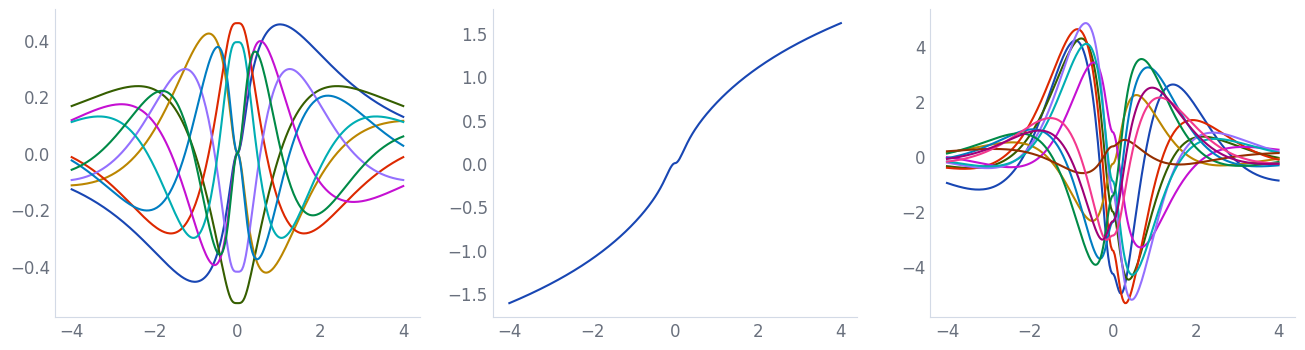

In [52]:
with pz.ts.active_autovisualizer.set_scoped(pz.ts.ArrayAutovisualizer()):
    pz.ts.display(trainer.state.params)

from scipy.stats import norm

Spline = trainer.model.layer_templ.spline_kind

layer: KANLayer = trainer.model.layer_templ
params = trainer.state.params

layer_i = 1
i = 10

layer_params = params[f'layers_{layer_i}']

base_xx = jnp.linspace(-4, 4, 258)

kernel = layer_params['coefs']['kernel']
in_dim, out_dim, n_coef = kernel.shape

xx = layer.input_map.apply({'params': layer_params.get('input_map', {})}, base_xx, layer.spline_kind)

if layer.spline_params_share:
    idx = lambda p: p
else:
    idx = lambda p: p[i]


spl_params = {param: idx(layer_params[param]) for param in layer.spline_kind.param_names()}

spl = Spline(kernel.shape[-1], **spl_params)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))
dm = jax.vmap(spl.design_matrix)(xx)
ax0.plot(base_xx, dm)
ax1.plot(base_xx, xx)

outputs = jnp.einsum('oc,ic->io', kernel[i], dm) + layer_params['coefs'].get('bias', jnp.zeros(in_dim))[i]
ax2.plot(base_xx, outputs[:, :12])


fig.suptitle(', '.join(f'{k} = {v:.03f}' for k, v in spl_params.items()))

- better initialization: figure out mathematically how to make each layer roughly the identity
  without using residuals
- figure out why deep networks don't work well. Can we add skip connections, or residuals, or
  something?
- Gaussian dropout
- Group neurons into different spline functions?
- Some kind of bounded rational function approach that's not a fourier series?
- Perhaps a wavelet approach

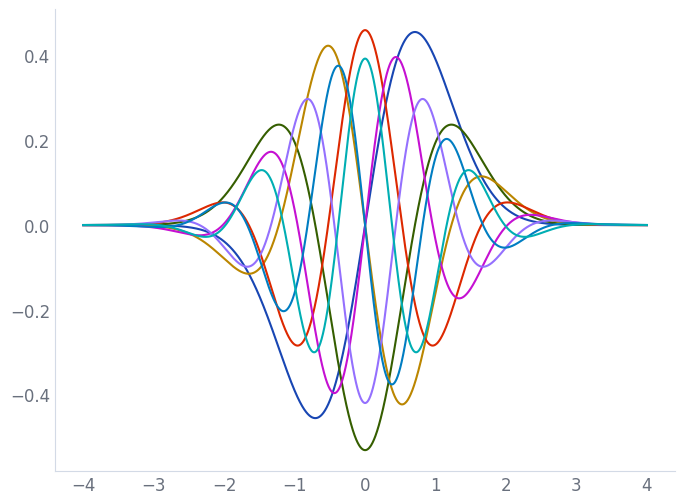

In [19]:
from jax_kan.function_basis import FunctionBasis
from jaxtyping import Float, Array


class Hermite(FunctionBasis):
    """Hermite polynomials (physicist's version.)"""

    def __init__(self, n_coefs: int):
        super().__init__(n_coefs)

    @property
    def n_coefs(self) -> int:
        return self._n_coefs

    def design_matrix(self, x: Float[Array, '']) -> Float[Array, 'coefs={self.n_coefs}']:
        polys = [1, 2 * x]

        for n in range(2, self.n_coefs + 1):
            polys.append(2 * x * polys[-1] - 2 * (n - 1) * polys[-2])

        nn = jnp.arange(self.n_coefs + 1)
        # scale = jnp.sqrt(jnp.pi) * 2 ** (n - 1) * jax.scipy.special.gamma(n)
        scale = jax.scipy.special.factorial(nn) * jnp.sqrt(jnp.pi) * 2 ** (nn)

        return jnp.array(polys[1: self.n_coefs+1]) / jnp.sqrt(scale[1:self.n_coefs+1])

    @classmethod
    def domain(cls) -> tuple[float, float]:
        return (-jnp.inf, jnp.inf) 

t_xx = jnp.linspace(-4, 4, 2000)
dm2 = jax.vmap(Hermite(8).design_matrix)(t_xx) * jnp.exp(-jnp.square(t_xx))[..., None]
norms = jax.vmap(lambda row: jnp.trapezoid(row * row * jnp.exp(-jnp.square(t_xx)), t_xx))(dm2.T)

plt.plot(t_xx, dm2)

In [12]:
dm2.T

Array([[ -4.2490077,  -4.2447567,  -4.240505 , ...,   4.2405057,
          4.244757 ,   4.2490077],
       [ 16.464895 ,  16.430902 ,  16.396944 , ...,  16.396948 ,
         16.430906 ,  16.464895 ],
       [-50.304836 , -50.143597 , -49.982685 , ...,  49.982708 ,
         50.143616 ,  50.304836 ]], dtype=float32)

In [8]:
from sympy import symbols

t = symbols('t')

Hermite(3).design_matrix(t)

[ 1.7724539  3.5449078 14.179648  85.07786  ]


TypeError: Value '2*t' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [12]:
from scipy.special import hermite

xx = jnp.linspace(-8, 8, 1000)
m = 3
jnp.trapezoid(jnp.polyval(hermite(m).coeffs, xx) * jnp.polyval(hermite(m).coeffs, xx) * jnp.exp(-xx**2), xx)

Array(85.07779, dtype=float32)

In [17]:
jax.scipy.special.gamma(m + 1) * 2 ** m * jnp.sqrt(jnp.pi)

Array(85.07786, dtype=float32, weak_type=True)

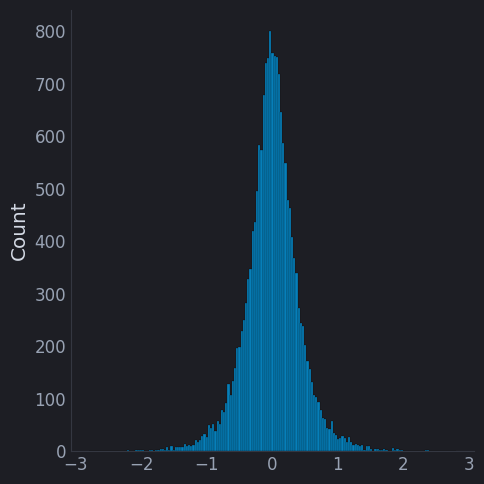

In [105]:
sns.displot(params['layers_0']['coefs']['kernel'].reshape(-1))

In [103]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split


X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = ExtraTreesClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.925